In [1]:
# Import libraries:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import warnings
from sqlalchemy import create_engine

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load the dataset from the database:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('SELECT * FROM studentsperformance', con=engine)

# Dispose open connection, as we're only doing a single query:
engine.dispose()

# Print out the first 5 rows of the dataset:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
# Check for missing values:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


{'whiskers': [<matplotlib.lines.Line2D at 0x1a1f266cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1f231cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1f266c90>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1f278e10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1f271f10>],
 'means': []}

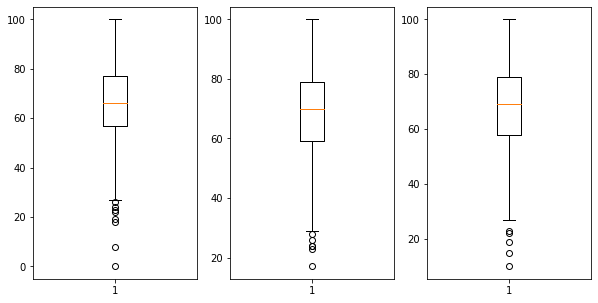

In [4]:
# Plot student scores using boxplot to spot outliners:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.boxplot(df['math score'])

plt.subplot(1,3,2)
plt.boxplot(df['reading score'])

plt.subplot(1,3,3)
plt.boxplot(df['writing score'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1a20a53f10>,
 'caps': [<matplotlib.lines.Line2D at 0x1a20a718d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a20a6c1d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a20a6ce90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a20a79850>],
 'means': []}

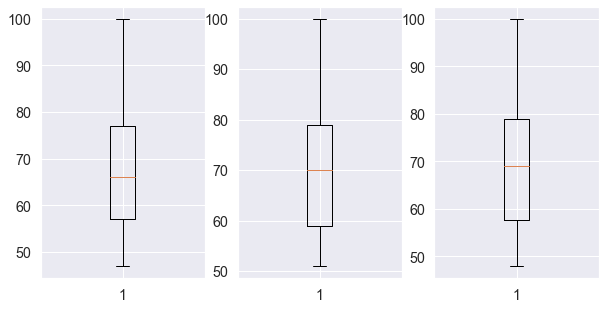

In [18]:
# Use one-way winsorization to eliminate outliners:
df['math score'] = winsorize(df['math score'], (0.1,0), inplace=True)
df['reading score'] = winsorize(df['reading score'], (0.1,0), inplace=True)
df['writing score'] = winsorize(df['writing score'], (0.1,0), inplace=True)
plt.figure(figsize=(10,5))

# Plot variables after winsorization, which eliminated outliners:
plt.subplot(1,3,1)
plt.boxplot(df['math score'])

plt.subplot(1,3,2)
plt.boxplot(df['reading score'])

plt.subplot(1,3,3)
plt.boxplot(df['writing score'])

### 1 - Are there any differences between the genders, ethnicities, and parental level of education with respect to their performances in exams?

In [6]:
# Student performance level by genders:
by_gender = df.groupby('gender')[['math score', 'reading score', 'writing score']].mean()
print(by_gender)
print('')

# Test whether group differences are statistically significant:
print(stats.ttest_ind(df[df.gender == 'female'][['math score', 'reading score', 'writing score']],
          df[df.gender == 'male'][['math score', 'reading score', 'writing score']]))

        math score  reading score  writing score
gender                                          
female   63.633205      73.214286      73.040541
male     68.728216      66.593361      64.317427

Ttest_indResult(statistic=array([-5.38324587,  8.31581703, 10.61395411]), pvalue=array([9.12018555e-08, 2.96126830e-16, 5.21608449e-25]))


As we can see from the statistics above, female students tend to score higher in reading and writing tests, while male students score higher in math. T-test result also shows that the differences are statistically significant.

In [7]:
# Student performace level by ethnicity:
by_ethnicity = df.groupby('race/ethnicity')[['math score', 'reading score', 'writing score']].mean()
print(by_ethnicity)

# Test whether group differences are statistically significant:
ethnicities = df['race/ethnicity'].unique()
grouped_df = df.groupby('race/ethnicity')
for var in ['math score', 'reading score', 'writing score']:
    print('------------------------------------------------')
    print('Comparisons for variable: {}'.format(var))
    print('------------------------------------------------')
    for i in range(0, len(ethnicities)):
        for j in range(i+1, len(ethnicities)):
            print('t-test between {0} and {1}:'.format(ethnicities[i], ethnicities[j]))
            print(stats.ttest_ind(df[df['race/ethnicity'] == ethnicities[i]][var],
               df[df['race/ethnicity'] == ethnicities[j]][var]))

                math score  reading score  writing score
race/ethnicity                                          
group A          61.629213      66.112360      63.898876
group B          63.452632      68.531579      66.847368
group C          64.463950      69.921630      68.564263
group D          67.362595      70.648855      70.599237
group E          73.821429      73.592857      71.992857
------------------------------------------------
Comparisons for variable: math score
------------------------------------------------
t-test between groups group B and group C:
Ttest_indResult(statistic=-0.7315669893534263, pvalue=0.4647708939167453)
t-test between groups group B and group A:
Ttest_indResult(statistic=0.9355076279747488, pvalue=0.3503415961659957)
t-test between groups group B and group D:
Ttest_indResult(statistic=-2.82845539712675, pvalue=0.004886197137104194)
t-test between groups group B and group E:
Ttest_indResult(statistic=-6.007397050552227, pvalue=5.007946047497971e-0

It looks like race/ethnicities have some impacts on student overall scores. The descriptive statistics above show group E has overall highest average scores for math, reading and writing tests, while group A has the lowest scores overall.

However, after conducting t-test statistics for different groups, we can see that not all of the differences in the mean values between groups are actually not statistically significant. For example, p value between group B and E are very high for math score, so we can't reject the null hypothesis.

In [8]:
# Student performance by parental level of education:
by_parent = df.groupby('parental level of education')[['math score', 'reading score', 'writing score']].mean()
print(by_parent)

# Test whether group differences are statistically significant:
parents = df['parental level of education'].unique()
grouped_df = df.groupby('parental level of education')
for var in ['math score', 'reading score', 'writing score']:
    print('------------------------------------------------')
    print('Comparisons for variable: {}'.format(var))
    print('------------------------------------------------')
    for i in range(0, len(parents)):
        for j in range(i+1, len(parents)):
            print('t-test between groups {0} and {1}:'.format(parents[i], parents[j]))
            print(stats.ttest_ind(df[df['parental level of education'] == parents[i]][var],
               df[df['parental level of education'] == parents[j]][var]))

                             math score  reading score  writing score
parental level of education                                          
associate's degree            67.882883      71.400901      70.279279
bachelor's degree             69.389831      73.364407      73.627119
high school                   62.137755      66.005102      63.637755
master's degree               69.745763      75.525424      75.711864
some college                  67.128319      70.292035      69.676991
some high school              63.497207      68.357542      66.251397
------------------------------------------------
Comparisons for variable: math score
------------------------------------------------
t-test between groups bachelor's degree and some college:
Ttest_indResult(statistic=1.3702352829617477, pvalue=0.17151224218471559)
t-test between groups bachelor's degree and master's degree:
Ttest_indResult(statistic=-0.14868196568849312, pvalue=0.8819757824867702)
t-test between groups bachelor's degr

The same method was used to analyze the impact of parental level of education on students scores. It looks like kids with parents that have a master's degree overall achieve higher scores on all subjects. However, after conducting t-test, we can notice that not all of the differences are statistically significant.

### 2 - Are there any differences between the lunch types with respect to their performances in exams? If there are, how do you explain this?

In [9]:
# Student performance by lunch types:
by_lunch = df.groupby('lunch')[['math score', 'reading score', 'writing score']].mean()
print(by_lunch)
print('')

# Test whether group differences are statistically significant:
print(stats.ttest_ind(df[df.lunch == 'free/reduced'][['math score', 'reading score', 'writing score']],
          df[df.lunch == 'standard'][['math score', 'reading score', 'writing score']]))

              math score  reading score  writing score
lunch                                                 
free/reduced   58.921127      66.236620      64.464789
standard       70.034109      72.106977      71.241860

Ttest_indResult(statistic=array([-11.83718047,  -6.99355093,  -7.70507269]), pvalue=array([2.41319560e-30, 4.90341475e-12, 3.14659061e-14]))


Text(0.5, 1.0, 'Writing score by lunch types')

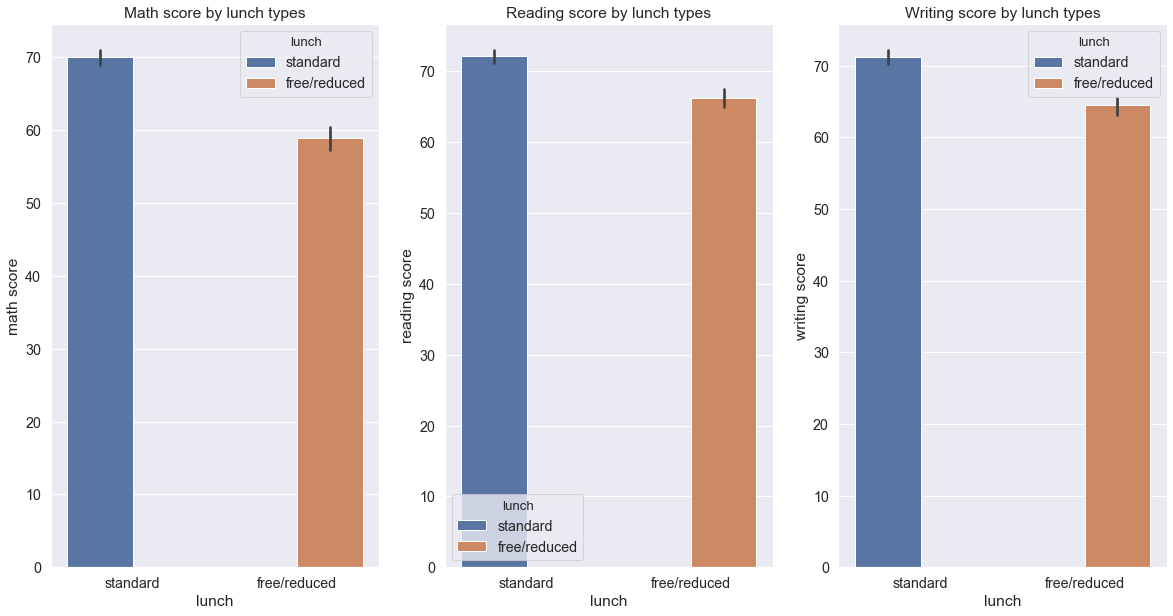

In [10]:
# Visualize performance by lunch types:
plt.figure(figsize = (20,10))
sns.set_style('darkgrid')
sns.set(font_scale=1.3)

plt.subplot(1,3,1)
sns.barplot(x='lunch', y='math score', hue='lunch', data=df)
plt.title('Math score by lunch types')

plt.subplot(1,3,2)
sns.barplot(x='lunch', y='reading score', hue='lunch', data=df)
plt.title('Reading score by lunch types')

plt.subplot(1,3,3)
sns.barplot(x='lunch', y='writing score', hue='lunch', data=df)
plt.title('Writing score by lunch types')

### 3 - Does the test preparation course seem to have an effect on the exam performances?

In [11]:
# Student performance by test preparation course:
by_testprep = df.groupby('test preparation course')[['math score', 'reading score', 'writing score']].mean()
print(by_testprep)
print('')

# Test whether group differences are statistically significant:
print(stats.ttest_ind(df[df['test preparation course'] == 'completed'][['math score', 'reading score', 'writing score']],
          df[df['test preparation course'] == 'none'][['math score', 'reading score', 'writing score']]))

                         math score  reading score  writing score
test preparation course                                          
completed                 69.695531      74.206704      74.603352
none                      64.077882      67.690031      65.619938

Ttest_indResult(statistic=array([ 5.70461642,  7.82366969, 10.47339485]), pvalue=array([1.53591346e-08, 1.30214139e-14, 2.00249872e-24]))


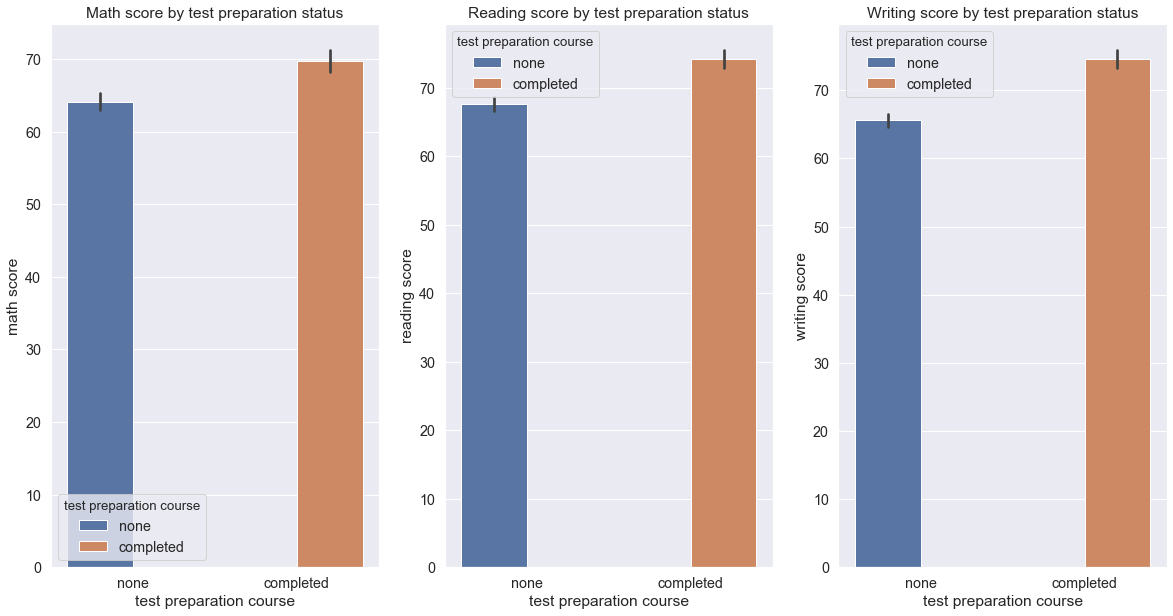

In [12]:
# Visualize performance by lunch types:
plt.figure(figsize = (20,10))
sns.set_style('darkgrid')
sns.set(font_scale=1.3)

plt.subplot(1,3,1)
sns.barplot(x='test preparation course', y='math score', hue='test preparation course', data=df)
plt.title('Math score by test preparation status')

plt.subplot(1,3,2)
sns.barplot(x='test preparation course', y='reading score', hue='test preparation course', data=df)
plt.title('Reading score by test preparation status')

plt.subplot(1,3,3)
sns.barplot(x='test preparation course', y='writing score', hue='test preparation course', data=df)
plt.title('Writing score by test preparation status')

plt.show()

### 4 - Which 2 exam scores are most correlated with each other?


In [13]:
# Create correlation matrix:
corr_map = df.corr()
corr_map

,math score,reading score,writing score
math score,1.000000,0.793045,0.776774
reading score,0.793045,1.000000,0.949719
writing score,0.776774,0.949719,1.000000


Text(0.5, 1, 'Score correlation matrix')

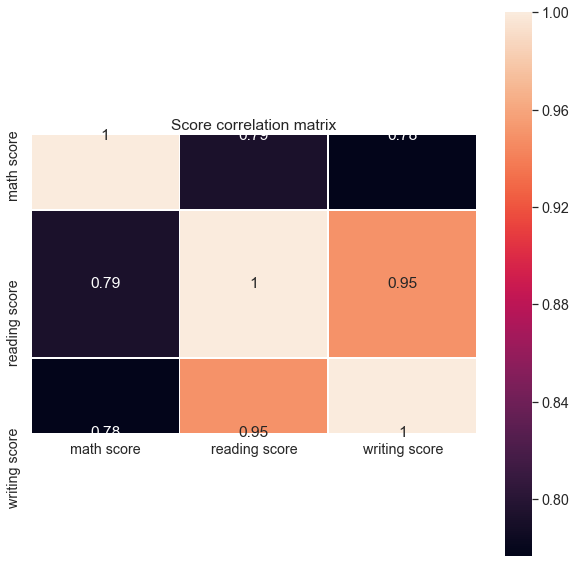

In [17]:
# Draw the heatmap using seaborn.:
plt.figure(figsize=(10,10))

sns.heatmap(corr_map, square=True, annot=True, linewidths=1)
plt.title('Score correlation matrix')

Observing from the heatmap above, we can see that reading score and writing score have the highest correlation.